In [9]:
import numpy as np
import pandas as pd
import dataframe_image as dfi
pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
from community import community_louvain
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
from ast import literal_eval

from scipy.spatial.distance import cdist

import json
from json import loads

import os
from os.path import join

import networkx as nx
from networkx.classes.function import set_node_attributes, density
from networkx.algorithms.distance_measures import diameter
from networkx.algorithms.shortest_paths import average_shortest_path_length
from networkx.algorithms.cluster import transitivity
from networkx import attribute_assortativity_coefficient
from networkx.algorithms.centrality import degree_centrality, betweenness_centrality, eigenvector_centrality
from networkx.drawing.nx_pydot import write_dot

In [37]:
ARTIST_PATH = './artist_df.csv'
EXP_FOLDER = 'louvain_experiments'
SAVE_FOLDER_NAME = 'louvain1_chebyshev'
SAVE_FOLDER_PATH = join(EXP_FOLDER, SAVE_FOLDER_NAME)
artist_df = pd.read_csv(ARTIST_PATH)

In [34]:
def make_artist_graph(artist_df, data_type=None, data=None, edge_weight_threshold=-np.inf):
    # aid -> artist id
    # nid -> node id
    def add_aid_nid_mapping(aid_nid_map, aid, nid):
        aid_nid_map[aid] = nid
        return nid
    if data_type == 'json':
        distance_fp = data
        true_artists = set()
        with open(distance_fp, 'r') as fp:
            paired_distance_strings = loads(fp.read())
        paired_distance_dictionary = {}
        for key, distance in paired_distance_strings.items():
            tuple_str = key.strip('()').split(',')
            artist_1 = tuple_str[0][1:-1]
            artist_2 = tuple_str[1][2:-1]
            true_artists.add(artist_1)
            true_artists.add(artist_2)
            pair = (artist_1, artist_2)
            paired_distance_dictionary[pair] = distance
        artist_df = artist_df[artist_df['artist_id'].isin(true_artists)]
        aid_nid_map = {}
        artist_df['node_id'] = artist_df.apply(lambda row: add_aid_nid_mapping(aid_nid_map, row['artist_id'], row.name), axis = 1)
        nid_aid_map = {nid: aid for (aid, nid) in aid_nid_map.items()}
        nid_list = artist_df['node_id'].tolist()
        artist_graph = nx.Graph()
        artist_graph.add_nodes_from(artist_df['node_id'].tolist())
        edge_attribute_list = []
        for key, distance in paired_distance_dictionary.items():
            artist_1, artist_2 = key
            nid_1, nid_2 = aid_nid_map[artist_1], aid_nid_map[artist_2]
            edge_attr_dict = {
                'weight': distance
            }
            edge = (nid_1, nid_2, edge_attr_dict)
            edge_attribute_list.append(edge)
        artist_graph.add_edges_from(edge_attribute_list)
        return artist_graph, aid_nid_map, nid_aid_map
    else:
        aid_nid_map = {}
        artist_df['node_id'] = artist_df.apply(lambda row: add_aid_nid_mapping(aid_nid_map, row['artist_id'], row.name), axis = 1)
        nid_aid_map = {nid: aid for (aid, nid) in aid_nid_map.items()}
        nid_list = artist_df['node_id'].tolist()
        artist_graph = nx.Graph()
        artist_graph.add_nodes_from(artist_df['node_id'].tolist())
        edge_attribute_list = []
        if data_type == 'matrix':
            for nid in nid_list[:-1]:
                for other_nid in nid_list[nid+1:]:
                    edge_weight = data[nid, other_nid]
                    if abs(edge_weight) > edge_weight_threshold:
                        weight_dict = {'weight': edge_weight}
                        edge = (nid, other_nid, weight_dict)
                        edge_attribute_list.append(edge)
            artist_graph.add_edges_from(edge_attribute_list)
        
        else:
            # Add the node attributes to the graph
            node_attrs_dict = {}
            for nid in nid_list:
                row = artist_df.iloc[nid]
                artist_attr_dict = {
                    'artist_name': row['artist_name'],
                    'total_plays': row['total_plays'],
                    'num_listeners': row['num_listeners'],
                    'play_ratio': row['play_ratio']
                }
                genres = row['genres'].replace("[", "").replace("]", "").replace("\'", "").split(', ')
                track_freq = json.loads(row['track_freq'].replace("\'", "\""))
                top_listeners = json.loads(row['top_listeners'].replace("\'", "\""))
                artist_attr_dict['genres'], artist_attr_dict['track_freq'], artist_attr_dict['top_listeners'] = \
                genres, track_freq, top_listeners
                node_attrs_dict[nid] = artist_attr_dict
            nx.set_node_attributes(artist_graph, node_attrs_dict)
            # create edge attributes and add them to the graph
            for nid in nid_list[:-1]:
                for other_nid in nid_list[nid+1:]:
                    nid_attr_dict, other_nid_attr_dict = artist_graph.nodes[nid], artist_graph.nodes[other_nid]
                    total_plays_abs_diff = abs(nid_attr_dict['total_plays'] - other_nid_attr_dict['total_plays'])
                    num_listeners_abs_diff = abs(nid_attr_dict['num_listeners'] - other_nid_attr_dict['num_listeners'])
                    play_ratio_abs_diff = abs(nid_attr_dict['play_ratio'] - other_nid_attr_dict['play_ratio'])
                    listener_overlap = len(set(nid_attr_dict['top_listeners'].keys()).intersection(
                        set(other_nid_attr_dict['top_listeners'].keys())
                    )) - 1
                    edge_attr_dict = {
                        'total_plays_abs_diff': total_plays_abs_diff,
                        'num_listeners_abs_diff': num_listeners_abs_diff,
                        'play_ratio_diff': play_ratio_abs_diff,
                        'listerner_overlap': listener_overlap
                    }
                    edge = (nid, other_nid, edge_attr_dict)
                    edge_attribute_list.append(edge)
            artist_graph.add_edges_from(edge_attribute_list)
        return artist_graph, aid_nid_map, nid_aid_map

def cluster_count(cluster_label, node_cluster_map):
    count = 0
    for nid, label in node_cluster_map.items():
        if label == cluster_label:
            count += 1
    return count

def calc_majority_labels(df, cluster_node_map, nid_aid_map):
    cluster_majority_label_map = {}
    for cid in cluster_node_map.keys():
        tag_counts = {}
        for nid in cluster_node_map[cid]:
            aid = nid_aid_map[nid]
            tag = df[df['artist_id'] == aid]['tag'].iloc[0]
            if tag in tag_counts:
                tag_counts[tag] += 1
            else:
                tag_counts[tag] = 1
        # calc majority label based on count
        max_label = None
        max_label_count = 0
        for tag, count in tag_counts.items():
            if count >= max_label_count:
                max_label_count = count
                max_label = tag
        
        cluster_majority_label_map[cid] = max_label
        
    return cluster_majority_label_map

def calc_accuracy(actual_tags, predicted_tags):
    N = len(actual_tags)
    num_correct = 0
    for actual, pred in zip(actual_tags, predicted_tags):
        if actual == pred:
            num_correct += 1
    return num_correct/N*100.0

def make_cluster_nodes_mapping(partition_map):
    cluster_nodes_mapping = {cid:[] for cid in set(partition_map.values())}
    for nid, cid in partition_map.items():
        if cid in cluster_nodes_mapping.keys():
            cluster_nodes_mapping[cid].append(nid)
            
    nodes_cluster_mapping = {nid:cid for cid in cluster_nodes_mapping.keys() for nid in cluster_nodes_mapping[cid]}
    
    return cluster_nodes_mapping, nodes_cluster_mapping

def get_large_clusters(cluster_nodes_mapping):
    large_clusters = [cid for cid in cluster_nodes_mapping.keys() if len(cluster_nodes_mapping[cid]) > 1]
    return large_clusters

def list_of_clustered_nodes(cluster_nodes_mapping, large_clusters):
    clustered_nodes = []
    for cid in large_clusters:
        clustered_nodes.extend(cluster_nodes_mapping[cid])
    return clustered_nodes

def predict_labels(cluster_majority_label_map, nodes_cluster_mapping, nid_aid_map, nodes_list):
    pred_labels_list = [cluster_majority_label_map[nodes_cluster_mapping[nid]] for nid in nodes_list]
    pred_labels_map = {nid_aid_map[nid]: cluster_majority_label_map[nodes_cluster_mapping[nid]] for nid in nodes_list}
    return pred_labels_list, pred_labels_map 

def get_actual_labels(artist_df, nid_aid_map, nodes_list):
    actual_labels = [artist_df[artist_df['artist_id'] == nid_aid_map[nid]]['tag'].iloc[0] for nid in nodes_list]
    return actual_labels

def get_graph_degree_dist(graph):
    degrees = [degree for _, degree in graph.degree(weight='weight')]
    return degrees

def make_log_degree_dist_plots(degree_data, title, save_fig_path):
    fig, axes = plt.subplots(1, 2, figsize=(16,5))  
    plt.subplot(1, 2, 1)
    plt.hist(degree_data, edgecolor='black', weights=np.zeros_like(degree_data) + 1. / len(degree_data), bins=300)
    plt.xscale('log')
    plt.title(title)
    plt.ylabel(r'Fraction $p_k$ of nodes with degree $k$')
    plt.xlabel(r'Degree $k$ (log scale)')
    plt.subplot(1, 2, 2)
    plt.hist(degree_data, edgecolor='black', weights=np.zeros_like(degree_data) + 1. / len(degree_data), log=True, bins=300)
    plt.xscale('log')
    plt.title(title)
    plt.ylabel(r'Fraction $p_k$ of nodes with degree $k$ (log scale)')
    plt.xlabel(r'Degree $k$ (log scale)')
    fig.savefig(save_fig_path)
    plt.show()

def louvain_experiment(artist_df, save_folder_name, 
                       data_type=None, data=None, 
                       edge_weight_threshold=-np.inf, 
                       edge_weight_metric='similarity'):
    try:
        os.mkdir(save_folder_name)
    except:
        print(save_folder_name, 'already exists. Overwriting...')
    
    artist_graph, aid_nid_map, nid_aid_map = make_artist_graph(artist_df, 
                                                               data_type, 
                                                               data, 
                                                               edge_weight_threshold)
    
    partition = community_louvain.best_partition(artist_graph, random_state=0)
    dendrogram = community_louvain.generate_dendrogram(artist_graph, random_state=0)
    modularity = community_louvain.modularity(partition, artist_graph)
    cluster_nodes_mapping, nodes_cluster_mapping = make_cluster_nodes_mapping(partition)

    cluster_majority_label_map = calc_majority_labels(artist_df, cluster_nodes_mapping, nid_aid_map)

    edgewidth = [d['weight'] for (u,v,d) in artist_graph.edges(data=True)]

    large_clusters = get_large_clusters(cluster_nodes_mapping)

    clustered_nodes = list_of_clustered_nodes(cluster_nodes_mapping, large_clusters)
    
    print('Optimal Modularity Found by Louvain: ', modularity)
    
    edge_density = density(artist_graph)
    degree_centrality_map = dict(artist_graph.degree(weight='weight'))
    betweenness_centrality_map = betweenness_centrality(artist_graph)

    print('Edge Density of Artist Network: ', edge_density)
    
    artist_id_list = list(aid_nid_map.keys())
    artist_names = [artist_df[artist_df['artist_id'] == artist_id]['artist_name'].iloc[0] for artist_id in artist_id_list]
    degree_centrality_list = [degree_centrality_map[aid_nid_map[artist_id]] for artist_id in artist_id_list]
    betweenness_centrality_list = [betweenness_centrality_map[aid_nid_map[artist_id]] for artist_id in artist_id_list]
    
    
    degree_centrality_df = pd.DataFrame({'Artist Name': artist_names, 'Degree Centrality': degree_centrality_list})
    degree_centrality_df.sort_values('Degree Centrality', ascending=False, inplace=True)
    betweenness_centrality_df = pd.DataFrame({'Artist Name': artist_names, 'Betweenness Centrality': betweenness_centrality_list})
    betweenness_centrality_df.sort_values('Betweenness Centrality', ascending=False, inplace=True)
    
    nodes_list = list(nid_aid_map.keys())
    
    predicted_labels, predicted_labels_map = predict_labels(cluster_majority_label_map, 
                                                        nodes_cluster_mapping, 
                                                        nid_aid_map, nodes_list)
    actual_labels = get_actual_labels(artist_df, nid_aid_map, nodes_list)
    
    accuracy_louvain = calc_accuracy(actual_labels, predicted_labels)
    print('Accuracy from Louvain Method at Clustering by Genre: ', f'{accuracy_louvain}%')
    
    # Plot heatmap of degree centrality
    clustered_nodes_subgraph = artist_graph.subgraph(clustered_nodes).copy()
    fig, axs = plt.subplots(figsize=(15,5))

    norm = mpl.colors.Normalize(vmin=min(degree_centrality_map.values()), vmax=max(degree_centrality_map.values())+1)
    cmap = cm.viridis
    pos = nx.spring_layout(clustered_nodes_subgraph)
    # color the nodes according to their partition
    # nx.draw(clustered_nodes_subgraph)
    nx.draw_networkx_edges(clustered_nodes_subgraph, pos, width=edgewidth)
    nx.draw_networkx_nodes(clustered_nodes_subgraph, pos, nodelist=clustered_nodes,
                           node_color=[degree_centrality_map[nid] for nid in clustered_nodes], 
                           node_size=[degree_centrality_map[nid] for nid in clustered_nodes],
                           cmap=cmap, label=clustered_nodes)
    plt.title('Largest Connected Components of the Artist Graph colored by Degree Centrality')
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
    fig.savefig(join(SAVE_FOLDER_PATH, 'degree_centrality_network.png'))
    plt.show()
    
    fig, axs = plt.subplots(figsize=(8,4))
    plt.axis('tight')
    plt.axis('off')
    plt.table(cellText=degree_centrality_df.head(10).values, 
                                colLabels=degree_centrality_df.columns,
                                colColours=["palegreen"]*2,
                                cellLoc='center',
                                loc='center')
    fig.tight_layout()
    fig.savefig(join(SAVE_FOLDER_PATH, 'degree_centrality_table.png'))
    plt.show()
    
    fig, axs = plt.subplots(figsize=(15,5))

    norm = mpl.colors.Normalize(vmin=min(betweenness_centrality_map.values()), vmax=max(betweenness_centrality_map.values())+1)
    cmap = cm.viridis
    pos = nx.spring_layout(clustered_nodes_subgraph)
    # color the nodes according to their partition
    # nx.draw(clustered_nodes_subgraph)
    nx.draw_networkx_edges(clustered_nodes_subgraph, pos, width=edgewidth)
    nx.draw_networkx_nodes(clustered_nodes_subgraph, pos, nodelist=clustered_nodes,
                           node_color=[betweenness_centrality_map[nid] for nid in clustered_nodes], 
                           node_size=[betweenness_centrality_map[nid]*100 for nid in clustered_nodes],
                           cmap=cmap, label=clustered_nodes)
    plt.title('Largest Connected Components of the Artist Graph colored by Betweenness Centrality')
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
    fig.savefig(join(SAVE_FOLDER_PATH, 'betweenness_centrality_network.png'))
    plt.show()
    
    fig, axs = plt.subplots(figsize=(8, 4))
    plt.axis('tight')
    plt.axis('off')
    plt.table(cellText=betweenness_centrality_df.head(10).values, 
              colLabels=betweenness_centrality_df.columns,
              colColours=["palegreen"]*2,
              cellLoc='center',
              loc='center')
    fig.tight_layout()
    fig.savefig(join(SAVE_FOLDER_PATH, 'betweenness_centrality_table.png'))
    plt.show()
    
    mpl_colors = ['tab:blue', 'tab:pink', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']
    
    cluster_color_map = {cid: mpl_colors[i]  for i, cid in enumerate(large_clusters)}
    node_colors = [cluster_color_map[nodes_cluster_mapping[nid]] for nid in clustered_nodes]
    node_sizes = {}
    
    for cid in large_clusters:
        cluster_nodes = cluster_nodes_mapping[cid]
        artist_ids = [nid_aid_map[nid] for nid in cluster_nodes]
        artist_names_cluster = [artist_df[artist_df['artist_id'] == artist_id]['artist_name'].iloc[0] 
                                 for artist_id in artist_ids]
        majority_label = cluster_majority_label_map[cid]
        cluster_graph = artist_graph.subgraph(cluster_nodes).copy()
        degree_centrality_map_cluster = degree_centrality_map = dict(cluster_graph.degree(weight='weight'))
        for nid in cluster_nodes:
            node_sizes[nid] = degree_centrality_map_cluster[nid]
        degree_centrality_cluster_list = [degree_centrality_map_cluster[aid_nid_map[artist_id]] 
                                               for artist_id in artist_ids]
        degree_centrality_cluster_df = pd.DataFrame(
            {
                'Artist Name': artist_names_cluster, 
                 'Degree Centrality': degree_centrality_cluster_list
            }
        )
        degree_centrality_cluster_df.sort_values('Degree Centrality', ascending=False, inplace=True)
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.table(cellText = degree_centrality_cluster_df.head(10).values,
                 colColours=[cluster_color_map[cid]]*2,
                 cellLoc='center',
                 loc='center',
                 colLabels = degree_centrality_cluster_df.columns,
             )
        ax.set_title(f"Cluster {cid}\n Majority Genre: {majority_label}")
        ax.axis("off")
        fig.tight_layout()
        fig.savefig(join(SAVE_FOLDER_PATH, f'cluster_{cid}_table.png'))
        plt.show()
        
    fig, axs = plt.subplots(figsize=(10,5))
    pos = nx.spring_layout(clustered_nodes_subgraph)
    # color the nodes according to their partition
    # nx.draw(clustered_nodes_subgraph)
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), 
                   markerfacecolor=color, markersize=10) for i, color in cluster_color_map.items()]
    # plot legend
    plt.title('Louvain Clusters for Connected Components of the Artist Graph')
    plt.legend(handles=legend_elements, loc='upper right')
    nx.draw_networkx_edges(clustered_nodes_subgraph, pos)
    nx.draw_networkx_nodes(clustered_nodes_subgraph, pos, nodelist=clustered_nodes,
                           node_color=node_colors)
    fig.savefig(join(SAVE_FOLDER_PATH, 'louvain_clusters.png'))
    plt.show()
    
    subcluster_degrees = get_graph_degree_dist(clustered_nodes_subgraph)
    make_log_degree_dist_plots(subcluster_degrees, 
                           'Degree distribution of Largest Connected Components of the Artist Graph', 
                           join(SAVE_FOLDER_PATH,'degree_dist_artist_graph.png'))
    
    induced_graph = community_louvain.induced_graph(partition, artist_graph)

    cluster_graph = induced_graph.subgraph(large_clusters).copy()
    cluster_weights = nx.get_edge_attributes(cluster_graph, 'weight')
    cluster_weights_keys = list(cluster_weights.keys())
    
    cluster_id1 = [key[0] for key in cluster_weights_keys]
    cluster_id2 = [key[1] for key in cluster_weights_keys]
    edge_weights = [cluster_weights[key] for key in cluster_weights_keys]
    
    cluster_nodes_df = pd.DataFrame({'Cluster ID 1': cluster_id1, 
                                 'Cluster ID 2': cluster_id2, 
                                 'Edge Weight': edge_weights})
    cluster_nodes_df.sort_values('Edge Weight', ascending=False, inplace=True)
    cluster_nodes_df = cluster_nodes_df.astype({'Cluster ID 1': 'int8', 'Cluster ID 2':'int8'})
    
    # draw the graph
    fig, axs = plt.subplots(figsize=(10,5))
    pos = nx.circular_layout(cluster_graph)
    # color the nodes according to their partition=
    cluster_weights_no_self_loops = {}
    for edge in cluster_weights.keys():
        if edge[0] == edge[1]:
            continue
        cluster_weights_no_self_loops[edge] = round(cluster_weights[edge], 2)
    nx.draw_networkx(cluster_graph, pos, font_color='w')
    nx.draw_networkx_nodes(cluster_graph, pos, nodelist=large_clusters, node_size=350, 
                           node_color=[cluster_color_map[nid] for nid in large_clusters])
    nx.draw_networkx_edges(cluster_graph, pos)
    nx.draw_networkx_edge_labels(cluster_graph, pos, edge_labels=cluster_weights_no_self_loops)
    plt.title('Super Nodes Found from Louvain Method on the Artist Graph')
    fig.savefig(join(SAVE_FOLDER_PATH, 'super_nodes_artist_graph_network.png'))
    plt.show()
    
    fig, axs = plt.subplots(figsize=(8,4))
    plt.axis('tight')
    plt.axis('off')
    plt.table(cellText=cluster_nodes_df.values, 
                                colLabels=cluster_nodes_df.columns,
                                colColours=["palegreen"]*3,
                                cellLoc='center',
                                loc='center')
    fig.tight_layout()
    fig.savefig(join(SAVE_FOLDER_PATH, 'super_nodes_artist_graph_table.png'))
    plt.show()
    
    data_dict = {
        'random_state': 0,
        'edge_weight_metric': 'edge_weight_metric',
        'data_type': data_type,
        'edge_weight_threshold': edge_weight_threshold,
        'louvain_accuracy': accuracy_louvain,
        'betweenness_centrality': betweenness_centrality_df['Betweenness Centrality'].tolist(),
        'betweenness_artist_names': betweenness_centrality_df.index.tolist(),
        'degree_centrality': degree_centrality_df['Degree Centrality'].tolist(),
        'degree_artist_names': degree_centrality_df.index.tolist(),
    }
    
    data_name = f'{SAVE_FOLDER_PATH}/{SAVE_FOLDER_NAME}.json'
    predicted_labels_name = f'{SAVE_FOLDER_PATH}/predicted_labels.json'
    
    with open(data_name, 'w') as outfile:
        json.dump(data_dict, outfile)
        
    with open(predicted_labels_name, 'w') as outfile:
        json.dump(predicted_labels_map, outfile)

    

louvain_experiments/louvain1_chebyshev already exists. Overwriting...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimal Modularity Found by Louvain:  4.218847493575595e-15
Edge Density of Artist Network:  1.0208333333333333
Accuracy from Louvain Method at Clustering by Genre:  34.02061855670103%


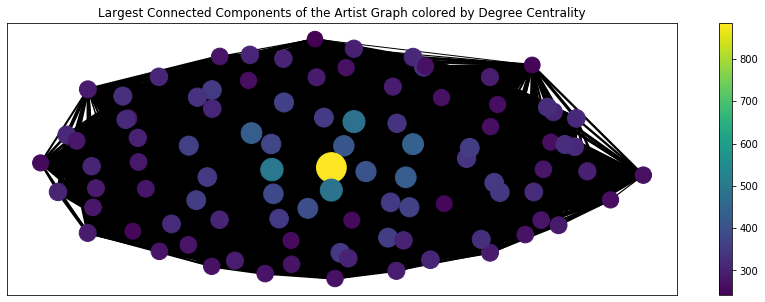

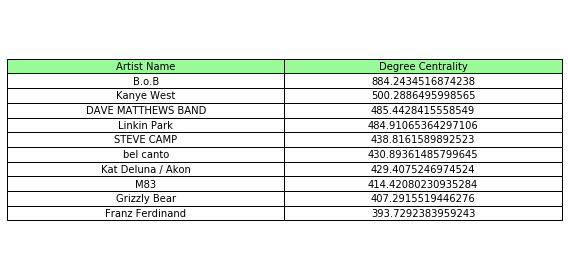

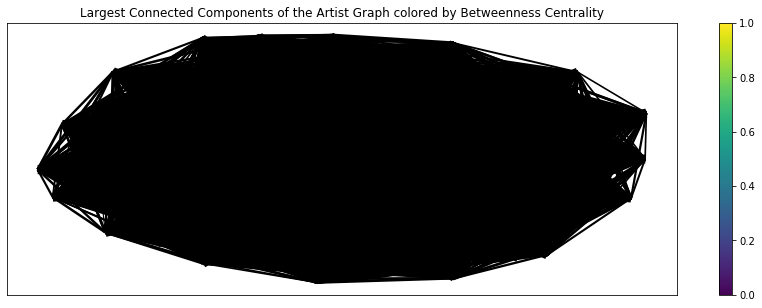

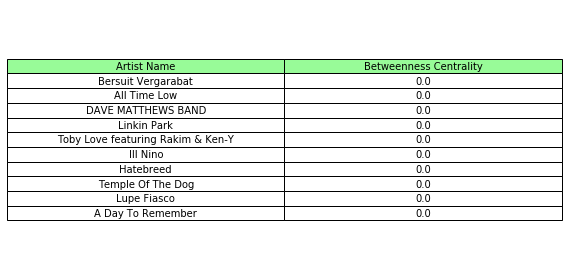

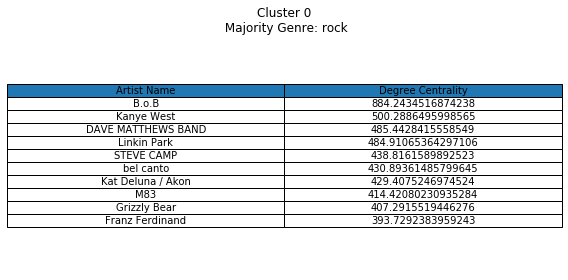

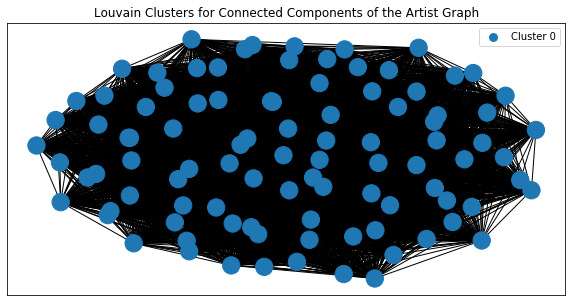

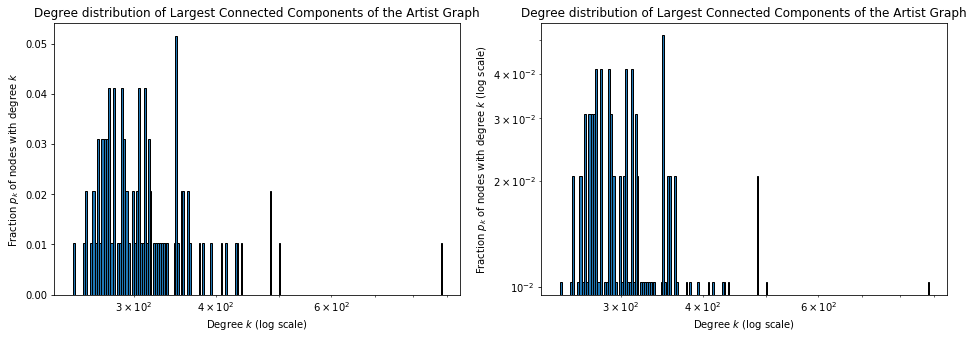

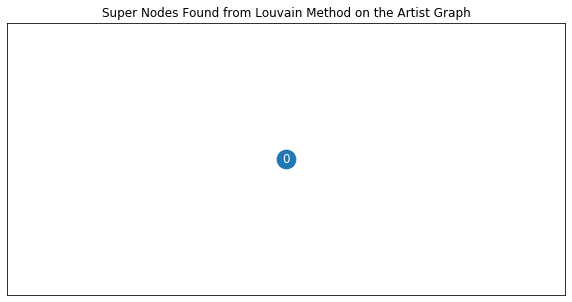

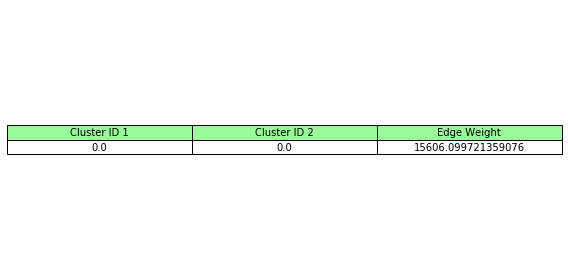

In [36]:
louvain_experiment(artist_df, SAVE_FOLDER_PATH, 
                       data_type='json', data='pair_distance_euclidean.json', 
                       edge_weight_threshold=-np.inf, 
                       edge_weight_metric='euclidean')

louvain_experiments/louvain1_chebyshev already exists. Overwriting...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimal Modularity Found by Louvain:  0.006002952970006456
Edge Density of Artist Network:  1.0208333333333333
Accuracy from Louvain Method at Clustering by Genre:  35.051546391752574%


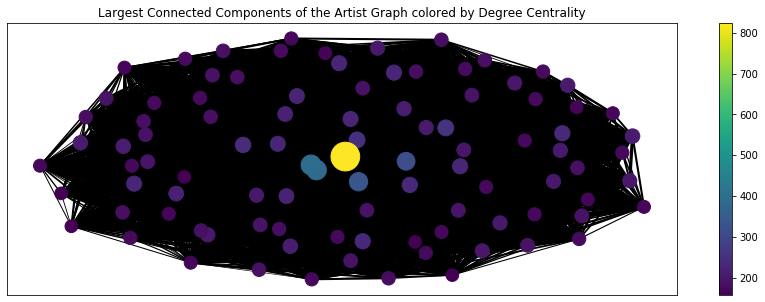

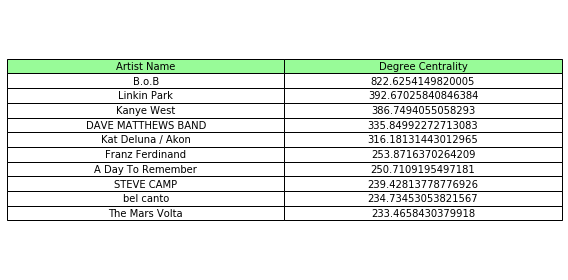

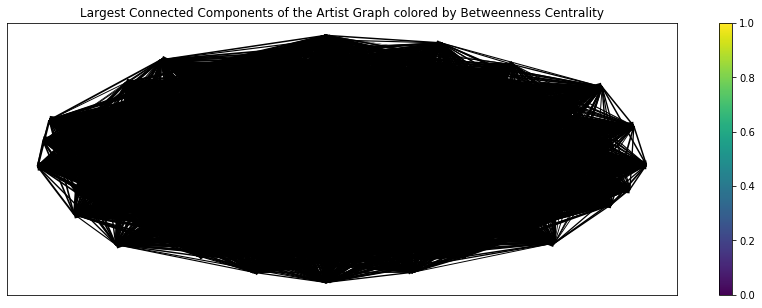

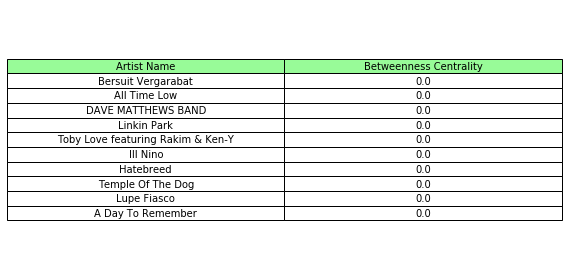

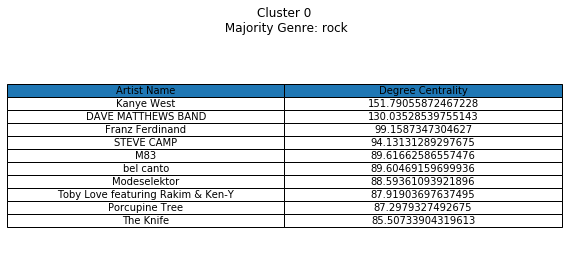

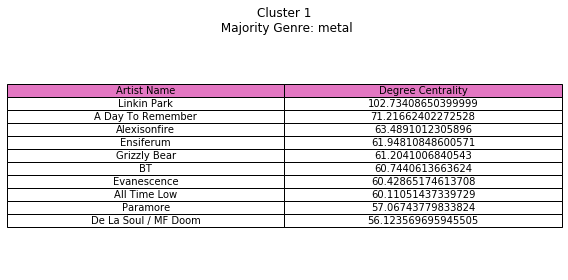

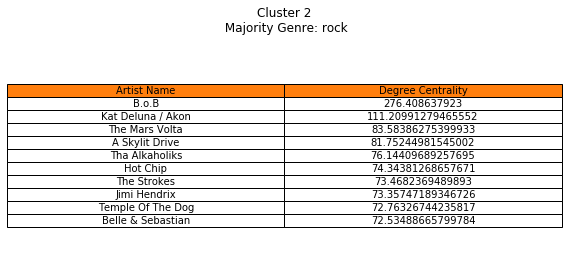

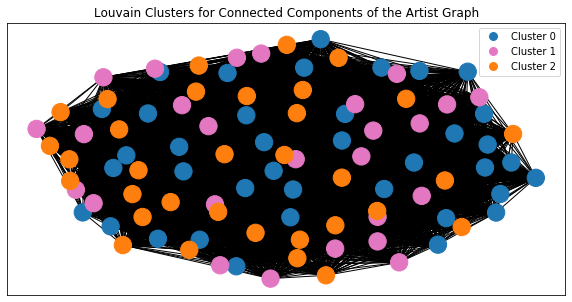

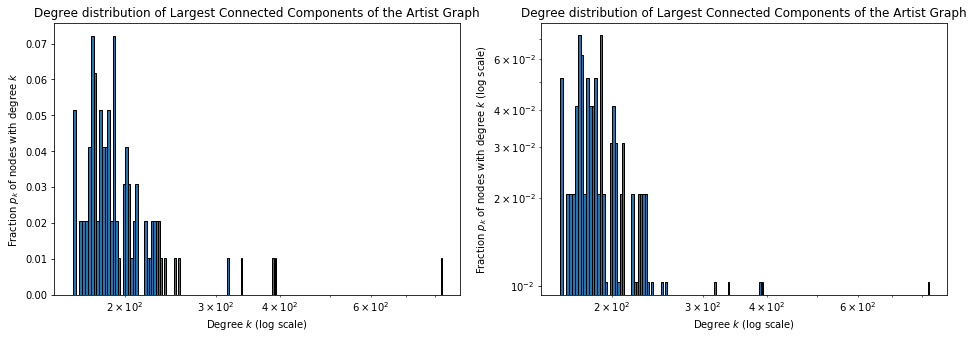

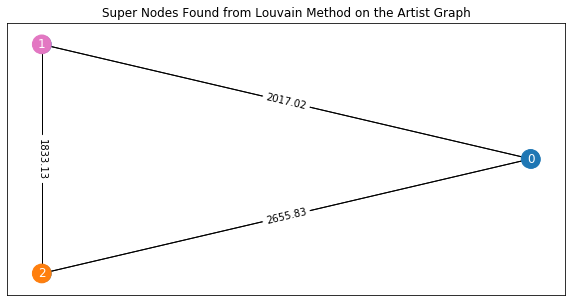

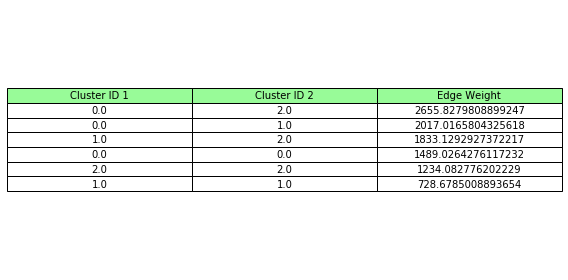

In [38]:
louvain_experiment(artist_df, SAVE_FOLDER_PATH, 
                       data_type='json', data='pair_distance_chebyshev.json', 
                       edge_weight_threshold=-np.inf, 
                       edge_weight_metric='chebyshev')